Based on: https://www.youtube.com/watch?v=jztwpsIzEGc

## Building Data Pipeline

#### Install Dependencies

In [1]:
#GPU compatibility only for tensorflow versions lower than 2.11
!pip install tensorflow opencv-python matplotlib

In [2]:
import tensorflow as tf
import os

In [3]:
#Set GPU Memory Consumption Growth (Limits tensorflow from using all the vRAM on GPU)
#By default, uses all potential vRAM, helps prevent OutOfMemory error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Image Data

In [5]:
import cv2 #Computer vision module
import imghdr #Checks image file extensions
from matplotlib import pyplot as plt

In [6]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
os.listdir(data_dir)

['lion', 'tiger']

Note for Additional cleanup: Manually delete any image files in data folders that are <10kb (too small for good data) or svg files

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            image = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))
#             os.remove(image_path)

#### Load Data

In [9]:
#Tensorflow dataset API: Allows to build a data pipeline instead of loading data to memory
#tf.data.Dataset

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
#Keras: API that provides a python interface for neural networks
#Data pipeline helper function via keras
#Does preprocessing as well, can be altered
data = tf.keras.utils.image_dataset_from_directory('data')

Found 404 files belonging to 2 classes.


In [12]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
#Gets next batch from numpy iterator, helpful for big data
batch = data_iterator.next()

In [15]:
len(batch) #2 = Images and labels

2

In [16]:
batch[1] #Labels

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0])

In [17]:
batch[0].shape

(32, 256, 256, 3)

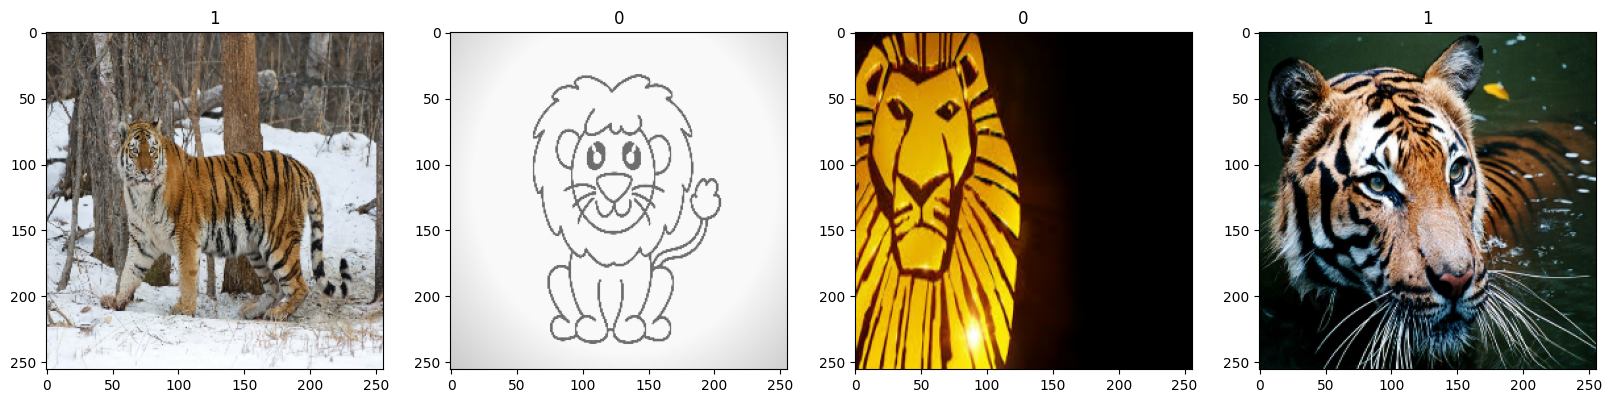

In [18]:
#Visualizes some images, sets title as their label
#0 = lion
#1 = tiger
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocessing

#### Scale Data

In [19]:
#Want channel values (RGB) to be as small as possible, to help optimize faster
#Divide by 255 (max possible RGB value)
scaled = batch[0]/255
scaled.max()
#Need a way to scale data while data is being loaded through data pipeline

1.0

In [20]:
#Maps function to dsatapoints in pipeline so data x value (which is the image values) get automatically scaled down
#y val = labels
#Allows a function to be conducted on multiple values throughout the dataset
data = data.map(lambda x,y: (x/255, y))

In [21]:
data.as_numpy_iterator().next()

(array([[[[0.7176471 , 0.6313726 , 0.5764706 ],
          [0.7176471 , 0.6313726 , 0.5764706 ],
          [0.7186649 , 0.6323904 , 0.5774884 ],
          ...,
          [0.7514008 , 0.66120476, 0.59845966],
          [0.74531454, 0.65511847, 0.5923734 ],
          [0.748816  , 0.6397014 , 0.58452374]],
 
         [[0.72156864, 0.63529414, 0.5803922 ],
          [0.72156864, 0.63529414, 0.5803922 ],
          [0.722258  , 0.63598347, 0.5810815 ],
          ...,
          [0.7490196 , 0.65882355, 0.59607846],
          [0.7435907 , 0.65339464, 0.59064955],
          [0.74868464, 0.63957006, 0.58439237]],
 
         [[0.7254902 , 0.6392157 , 0.58431375],
          [0.7254902 , 0.6392157 , 0.58431375],
          [0.7264434 , 0.6401689 , 0.58526695],
          ...,
          [0.74509805, 0.654902  , 0.5921569 ],
          [0.73751014, 0.6473141 , 0.584569  ],
          [0.7485532 , 0.6394386 , 0.58426094]],
 
         ...,
 
         [[0.68774843, 0.5817282 , 0.49937528],
          [0.75042

#### Split Data

In [22]:
len(data)

13

In [23]:
#70% training data, 20% validating data, 10% testing data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1 #Only used for evaluation

In [24]:
train_size + val_size + test_size

13

In [25]:
train = data.take(train_size) #Takes only number of batches from data specified by train_size
val = data.skip(train_size).take(val_size) #Skips first part of data already assigned to training data and takes val_size amount after
test = data.skip(train_size+val_size).take(test_size)

## Building Deep Neural Network

#### Build Deep Learning Model

In [26]:
from tensorflow.keras.models import Sequential #Good for 1 data input and 1 output
#use Functional for multiple inputs/outputs/connections
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow import keras

In [27]:
model = Sequential()

In [28]:
#16 filters, filter is 3x3 pixels, stride = 1 (moves 1 pixel at a time)
#Activations: Take in output data and modify the outputs via a function to fit certain parameters
#relu activation function takes output and converts <0 outputs to 0, and preserves positive values
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3))) #First layer is input layer
model.add(MaxPooling2D()) #Takes and returns max values after relu activation, condenses

#32 filters
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

#16 filters
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) #Condenses to single dimension

#Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #Single output, 1 dimension

In [29]:
#adam = optimizer
#SparseCategoricalCrossentropy used when there are 2+ possible y_values, and they are mutually exclusive (only 1 label per input)
opt = keras.optimizers.Adam(0.0005)
model.compile(optimizer=opt, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

#### Train

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
#Epoch = A run over our entire training set, the more epochs = better understanding
#TOO many epochs could mean too much accuracy for only training data, not very usable
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback], shuffle=True)

Epoch 1/20
9/9 [==============================] - 7s 313ms/step - loss: 0.8949 - accuracy: 0.4826 - val_loss: 0.7159 - val_accuracy: 0.4688
Epoch 2/20
9/9 [==============================] - 4s 358ms/step - loss: 0.6909 - accuracy: 0.6111 - val_loss: 0.6826 - val_accuracy: 0.4531
Epoch 3/20
9/9 [==============================] - 5s 353ms/step - loss: 0.6777 - accuracy: 0.5625 - val_loss: 0.6663 - val_accuracy: 0.7969
Epoch 4/20
9/9 [==============================] - 4s 343ms/step - loss: 0.6490 - accuracy: 0.7222 - val_loss: 0.5958 - val_accuracy: 0.8125
Epoch 5/20
9/9 [==============================] - 4s 358ms/step - loss: 0.5843 - accuracy: 0.7535 - val_loss: 0.5688 - val_accuracy: 0.6406
Epoch 6/20
9/9 [==============================] - 5s 359ms/step - loss: 0.5780 - accuracy: 0.6771 - val_loss: 0.4872 - val_accuracy: 0.7812
Epoch 7/20
9/9 [==============================] - 4s 356ms/step - loss: 0.4792 - accuracy: 0.8056 - val_loss: 0.4532 - val_accuracy: 0.7969
Epoch 8/20
9/9 [====

In [34]:
hist.history

{'loss': [0.8949267268180847,
  0.6908942461013794,
  0.6776520609855652,
  0.6489883661270142,
  0.5843298435211182,
  0.5780287981033325,
  0.47920480370521545,
  0.4226503372192383,
  0.3436543643474579,
  0.32520556449890137,
  0.2954502999782562,
  0.2602088749408722,
  0.2658952474594116,
  0.17842833697795868,
  0.14010058343410492,
  0.1131574809551239,
  0.15238027274608612,
  0.14656254649162292,
  0.09862156957387924,
  0.09321991354227066],
 'accuracy': [0.4826388955116272,
  0.6111111044883728,
  0.5625,
  0.7222222089767456,
  0.7534722089767456,
  0.6770833134651184,
  0.8055555820465088,
  0.8472222089767456,
  0.8854166865348816,
  0.8541666865348816,
  0.8819444179534912,
  0.8854166865348816,
  0.9027777910232544,
  0.9479166865348816,
  0.96875,
  0.9618055820465088,
  0.9305555820465088,
  0.9444444179534912,
  0.9756944179534912,
  0.9826388955116272],
 'val_loss': [0.7158980369567871,
  0.6825820207595825,
  0.666294276714325,
  0.5957642793655396,
  0.5687994360

#### Plot Performance

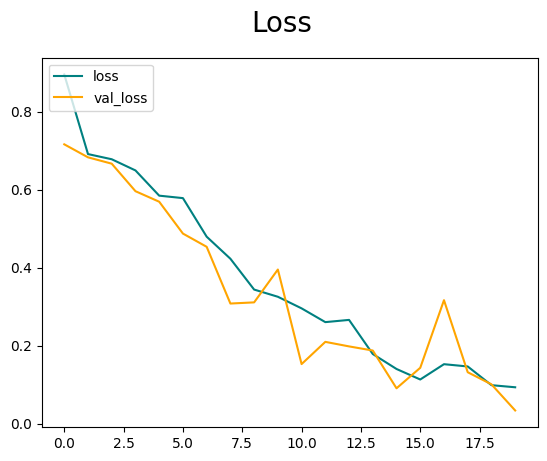

In [35]:
#If loss is decreasing but val_loss starts to increase, that is a sign of possible overfitting
#No change in loss or val_loss means training data should be looked at, or a more sophisticated nn, shows inability to learn 
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle("Loss", fontsize=20)
plt.legend(loc='upper left')
plt.show()

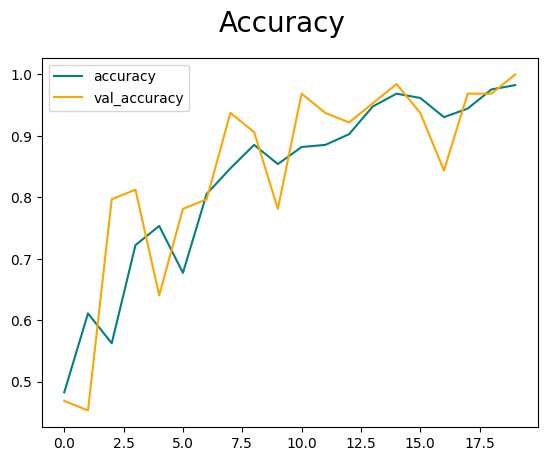

In [36]:
#Accuracy Plotted
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Model Evaluation

#### Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
recall = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    recall.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 142ms/step


In [40]:
print(f'Precision: {pre.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


#### Testing

In [41]:
import cv2

1/1 [==============================] - 0s 62ms/step
[[0.43251893]]
Predicted class is lion


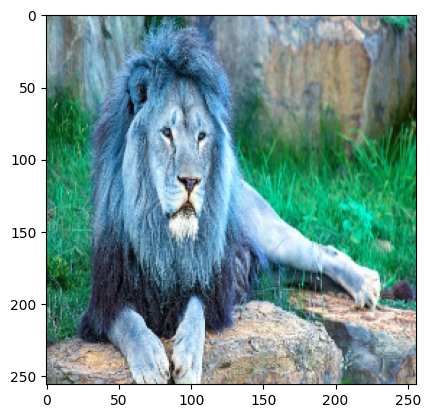

In [42]:
img = cv2.imread('lion-test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #Changes channels to RGB, outputs image as normal
resize = tf.image.resize(img, (256,256)) #Resize to be 256x256 and 3 channels
plt.imshow(resize.numpy().astype(int))
yhat = model.predict(np.expand_dims(resize/255, 0)) #Image needs to be put into array so model can take it in as a batch, use expand_dims
print(yhat)
if yhat < 0.5:
    print('Predicted class is lion')
else:
    print('Predicted class is tiger')

## Save Model

In [43]:
from tensorflow.keras.models import load_model

In [44]:
model.save(os.path.join('models','imageclassifier.h5'))